In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys
import warnings
import tqdm
sys.path.append('..')

C:\Users\applepy\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import xgboost as xgb
import yaml
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
import optuna
from functools import partial
import scipy.spatial.distance as ssd
from sklearn.decomposition import PCA

In [3]:
import src.dax_utils as utils

In [4]:
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('bmh')
warnings.filterwarnings("ignore")

In [5]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

### Constants

In [6]:
FEATURE_SELECTION_AUC_DROP_THRESHOLD = .05

### Read in artifacts

In [7]:
X_train = pd.read_csv('dataset/X_train.csv', index_col=0, parse_dates=[0])
y_train = pd.read_csv('dataset/y_train.csv', index_col=0, parse_dates=[0])
X_test = pd.read_csv('dataset/X_test.csv', index_col=0, parse_dates=[0])
y_test = pd.read_csv('dataset/y_test.csv', index_col=0, parse_dates=[0])

### Baseline model

In [8]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [9]:
y_prob = xgb_model.predict_proba(X_test)
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

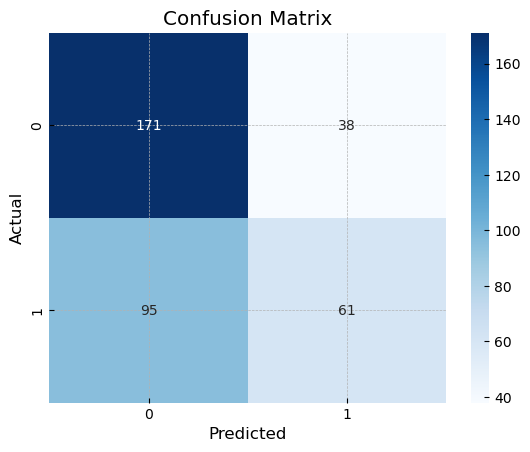

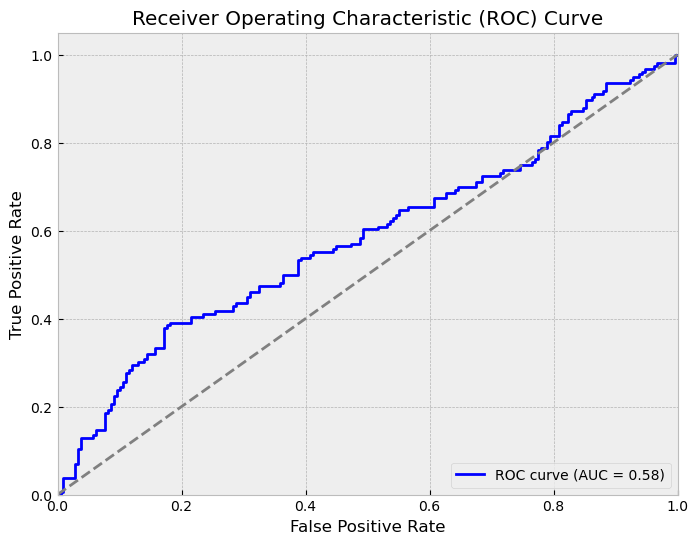

              precision    recall  f1-score   support

           0       0.64      0.82      0.72       209
           1       0.62      0.39      0.48       156

    accuracy                           0.64       365
   macro avg       0.63      0.60      0.60       365
weighted avg       0.63      0.64      0.62       365



In [10]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Feature Selection

In [11]:
X_sm_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_sm_train)
results = model.fit()

         Current function value: 0.610803
         Iterations: 35


In [12]:
number_of_significant_features = (results.pvalues < .05).sum() # 42

In [13]:
number_of_significant_features

7

In [14]:
results.pvalues[results.pvalues < .05].sort_values().head(15)

const                 0.00
sunrise_dusk          0.00
close_bnd_vol5d       0.01
low_gld_low_vol5d     0.01
close_ief_vol5d       0.02
month_length          0.03
close_bnd close_ief   0.03
dtype: float64

In [15]:
tree_based_feature_importances = utils.Tools.get_tree_model_feature_importances(xgb_model, X_train.columns)

In [16]:
tree_based_feature_importances.head(15)

non_business_days_in_month   0.01
month_first_day              0.01
low_spy_low_vol5d            0.01
savgol_close_ief_w5_p2       0.01
sunrise_dusk                 0.01
close_ief_spy_corr30d        0.01
year_days_left               0.01
close_ief_gdaxi_corr10d      0.01
year_days_passed             0.01
low_bnd                      0.01
business_days_in_month       0.01
month_days_passed            0.01
close_ief_spy_corr10d        0.01
close_bnd_ief_corr30d        0.01
month_length                 0.01
dtype: float32

### Recurise Feature Elimination with Custom TimeSeriesSplit

In [17]:
# baseline_score = roc_auc_score(y_test, y_prob[:,1])
# baseline_score

In [18]:
scores = list()
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=3)

for train_index, test_index in timeseries_splitter.split(X_train):
    # print("TRAIN:", len(train_index), "TEST:", len(test_index))
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    
    scores.append(
        roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:])[:,1])
    )

In [19]:
baseline_score = np.array(scores).mean()
baseline_score

0.5894677092122046

In [20]:
import importlib
importlib.reload(utils)

<module 'src.dax_utils' from 'E:\\working\\pet-project\\investment-2024\\daxex\\_repo\\dax-24-strat\\proof_of_concept\\..\\src\\dax_utils.py'>

In [21]:
# del RFE_FEATURES; del _RFE_FEATURES

In [22]:
big_step, small_step = 10, 5
timeseries_splitter = utils.ReasonableTimeSeriesSplit(n_splits=6)
number_of_features = X_train.columns.shape[0] - big_step
step = big_step
current_score = baseline_score
all_scores = {}

progress_bar = tqdm.tqdm(total=number_of_features, desc="Processing")

n = 0
while current_score > (baseline_score - FEATURE_SELECTION_AUC_DROP_THRESHOLD) and number_of_features > 0:
    try:
        RFE_FEATURES = _RFE_FEATURES.copy()
    except NameError:
        RFE_FEATURES = X_train.columns
    
    rfe = RFE(estimator=xgb_model, n_features_to_select=number_of_features)
    rfe.fit(X_train[RFE_FEATURES], y_train)
    
    _RFE_FEATURES = X_train[RFE_FEATURES].columns[rfe.support_]
    
    scores = list()
    for train_index, test_index in timeseries_splitter.split(X_train):
        # print("TRAIN:", len(train_index), "TEST:", len(test_index))
        xgb_model = xgb.XGBClassifier(random_state=42)
        xgb_model.fit(X_train.iloc[train_index,:].loc[:,_RFE_FEATURES], y_train.iloc[train_index])

        scores.append(
            roc_auc_score(y_train.iloc[test_index], xgb_model.predict_proba(X_train.iloc[test_index,:].loc[:,_RFE_FEATURES])[:,1])
        )

    current_score = np.array(scores).mean()
    all_scores[number_of_features] = scores.copy()
    
    if n % 5 == 0:
        FEATURE_SELECTION_AUC_DROP_THRESHOLD = FEATURE_SELECTION_AUC_DROP_THRESHOLD - .01
        step = step - 1
        
    number_of_features = number_of_features - step
    progress_bar.set_description(f"Processing (AUC: {current_score:.4f})")
    progress_bar.update(step)
    n += 1

progress_bar.close()

Processing (AUC: 0.5890):  70%|█████████████████████████████████████▌                | 170/244 [03:41<01:36,  1.30s/it]


In [23]:
RFE_FEATURES

Index(['low_ief', 'low_gdaxi', 'open_bnd', 'open_ief', 'open_gdaxi',
       'volume_gld_day1', 'volume_ief_day1', 'volume_spy_day1',
       'volume_gdaxi_day1', 'close_gld_day1', 'close_spy_day1',
       'high_gld_day3', 'open_bnd_day3', 'volume_spy_day3', 'close_bnd_day3',
       'close_gdaxi_day3', 'low_bnd_day7', 'high_gdaxi_day7', 'open_bnd_day7',
       'open_gdaxi_day7', 'low_gld_day20', 'close_gdaxi_day20',
       'year_days_passed', 'year_days_left', 'month_days_passed',
       'month_first_day', 'month_length', 'last_friday', 'sunrise_dusk',
       'business_days_in_month', 'non_business_days_in_month', 'bnd_rsi',
       'gld_rsi', 'gdaxi_rsi', 'gld_stochastic_oscillator',
       'ief_stochastic_oscillator', 'spy_stochastic_oscillator',
       'close_bnd_vol5d', 'close_gld_vol5d', 'close_ief_vol3d',
       'close_ief_vol5d', 'close_spy_vol3d', 'close_spy_vol5d',
       'close_gdaxi_vol5d', 'high_bnd_high_vol5d', 'high_gld_high_vol3d',
       'high_gld_high_vol5d', 'high_ief_hi

### Test Reduced Feature Set

In [24]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

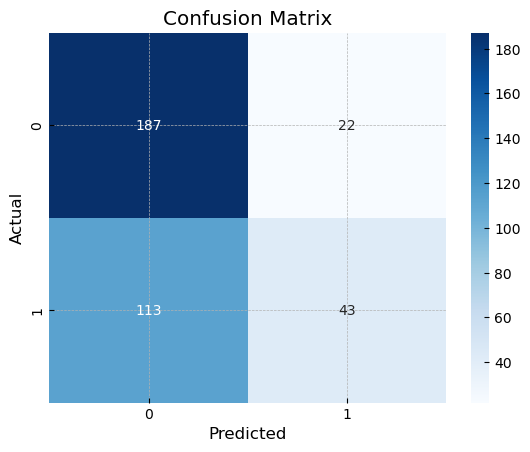

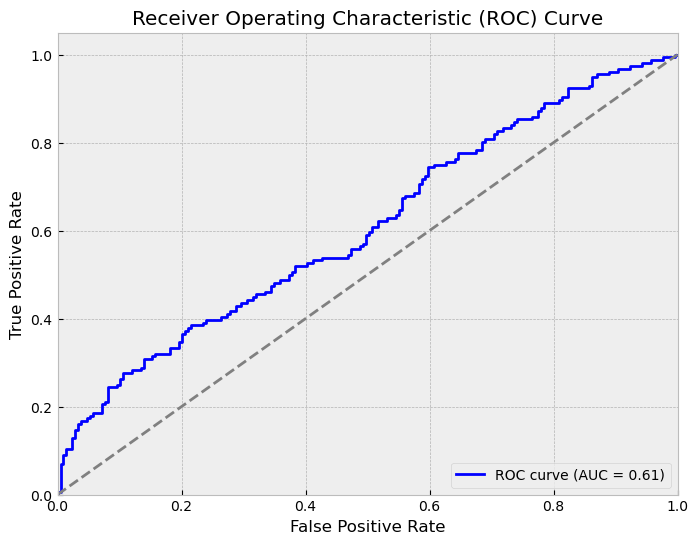

              precision    recall  f1-score   support

           0       0.62      0.89      0.73       209
           1       0.66      0.28      0.39       156

    accuracy                           0.63       365
   macro avg       0.64      0.59      0.56       365
weighted avg       0.64      0.63      0.59       365



In [26]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)

### Hyperparam optimization

In [27]:
def objective_xgboost_classification(X_train, y_train, trial):

    _X_train, X_valid = X_train[:int(X_train.shape[0] * .7)], X_train[int(X_train.shape[0] * .7):]
    _y_train, y_valid = y_train[:int(X_train.shape[0] * .7)], y_train[int(X_train.shape[0] * .7):]

    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 900, 1500),
        'max_depth': trial.suggest_int('max_depth', 8, 18),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-4, 1e-1),
        'min_child_weight': trial.suggest_int('min_child_weight', 6, 9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e-1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e-1),
        'use_label_encoder': False,
        'eval_metric': 'auc',
        'verbose' : -1
    }

    
    # Initialize the XGBoost classifier model with hyperparameters
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Train the model
    model.fit(_X_train, _y_train)
    
    # Evaluate the model on the validation set using AUC
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_pred_proba)
    # score = recall_score(y_valid, y_pred_proba)
    
    return score 

In [28]:
# Define the study and optimize hyperparameters
study_xgboost_classification = optuna.create_study(direction='maximize')
objective = partial(objective_xgboost_classification, X_train.loc[:,RFE_FEATURES], y_train)
study_xgboost_classification.optimize(objective, n_trials=200)

[I 2024-06-23 16:49:22,462] A new study created in memory with name: no-name-f3ebed35-56fc-41c7-9cd0-29471c31be37
[I 2024-06-23 16:49:26,196] Trial 0 finished with value: 0.5749762524627076 and parameters: {'n_estimators': 1468, 'max_depth': 14, 'learning_rate': 0.02099059909851565, 'subsample': 0.7273701978247848, 'colsample_bytree': 0.9266115477829504, 'gamma': 0.027818622154279753, 'min_child_weight': 9, 'reg_alpha': 0.005645695061831332, 'reg_lambda': 0.017240686007298528}. Best is trial 0 with value: 0.5749762524627076.
[I 2024-06-23 16:49:28,541] Trial 1 finished with value: 0.5728961441035744 and parameters: {'n_estimators': 1046, 'max_depth': 13, 'learning_rate': 0.06221307329036442, 'subsample': 0.9464703732657818, 'colsample_bytree': 0.87769560279089, 'gamma': 0.06175202708041806, 'min_child_weight': 6, 'reg_alpha': 0.06498984699659914, 'reg_lambda': 0.09478416324264934}. Best is trial 0 with value: 0.5749762524627076.
[I 2024-06-23 16:49:30,765] Trial 2 finished with value: 

[I 2024-06-23 16:50:37,045] Trial 20 finished with value: 0.5776808330987897 and parameters: {'n_estimators': 993, 'max_depth': 9, 'learning_rate': 0.06919533958229233, 'subsample': 0.959817664068894, 'colsample_bytree': 0.967539280646446, 'gamma': 0.08806441440743742, 'min_child_weight': 8, 'reg_alpha': 0.048804737131907645, 'reg_lambda': 0.0320203456507739}. Best is trial 11 with value: 0.5806888544891641.
[I 2024-06-23 16:50:38,802] Trial 21 finished with value: 0.5764758654658035 and parameters: {'n_estimators': 968, 'max_depth': 9, 'learning_rate': 0.07170457114041916, 'subsample': 0.9975376769869683, 'colsample_bytree': 0.9706428803441332, 'gamma': 0.08834392459213532, 'min_child_weight': 8, 'reg_alpha': 0.04961048582205757, 'reg_lambda': 0.031340838693456885}. Best is trial 11 with value: 0.5806888544891641.
[I 2024-06-23 16:50:40,687] Trial 22 finished with value: 0.5606133900928792 and parameters: {'n_estimators': 1022, 'max_depth': 9, 'learning_rate': 0.07995998843685626, 'su

[I 2024-06-23 16:51:40,805] Trial 40 finished with value: 0.573208380242049 and parameters: {'n_estimators': 901, 'max_depth': 16, 'learning_rate': 0.0052528157653938656, 'subsample': 0.8963969895313035, 'colsample_bytree': 0.9939637283593519, 'gamma': 0.055428807051714796, 'min_child_weight': 9, 'reg_alpha': 0.038394880999551864, 'reg_lambda': 0.051124918585910784}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:51:45,548] Trial 41 finished with value: 0.5779315015479877 and parameters: {'n_estimators': 976, 'max_depth': 11, 'learning_rate': 0.010543682280435637, 'subsample': 0.9810093582173245, 'colsample_bytree': 0.9170626108184292, 'gamma': 0.018770221959882285, 'min_child_weight': 7, 'reg_alpha': 0.052241200242874763, 'reg_lambda': 0.03701840946710273}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:51:49,410] Trial 42 finished with value: 0.5732171756262313 and parameters: {'n_estimators': 984, 'max_depth': 12, 'learning_rate': 0.018315236472

[I 2024-06-23 16:53:00,027] Trial 60 finished with value: 0.5661808682803264 and parameters: {'n_estimators': 970, 'max_depth': 12, 'learning_rate': 0.012277238942681533, 'subsample': 0.9043763722591613, 'colsample_bytree': 0.9762536516816028, 'gamma': 0.011442880586480858, 'min_child_weight': 7, 'reg_alpha': 0.08325047766017918, 'reg_lambda': 0.010057930262827138}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:53:04,531] Trial 61 finished with value: 0.5741714748100196 and parameters: {'n_estimators': 995, 'max_depth': 10, 'learning_rate': 0.0073730083292107285, 'subsample': 0.7081770138056835, 'colsample_bytree': 0.9680649379212939, 'gamma': 0.008494251040858462, 'min_child_weight': 7, 'reg_alpha': 0.04958667125136773, 'reg_lambda': 0.02606939332958253}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:53:08,251] Trial 62 finished with value: 0.5769859977483816 and parameters: {'n_estimators': 930, 'max_depth': 9, 'learning_rate': 0.01229092376968

[I 2024-06-23 16:54:19,275] Trial 80 finished with value: 0.5763175485505208 and parameters: {'n_estimators': 900, 'max_depth': 13, 'learning_rate': 0.004205974659157369, 'subsample': 0.6913234389491788, 'colsample_bytree': 0.8727594677110702, 'gamma': 0.06758614114465047, 'min_child_weight': 6, 'reg_alpha': 0.05728624410730286, 'reg_lambda': 0.05470768263676454}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:54:24,196] Trial 81 finished with value: 0.5704642203771461 and parameters: {'n_estimators': 959, 'max_depth': 14, 'learning_rate': 0.007828793399412632, 'subsample': 0.7312525559873067, 'colsample_bytree': 0.8967360842257684, 'gamma': 0.07429051865083404, 'min_child_weight': 6, 'reg_alpha': 0.06031461205424578, 'reg_lambda': 0.0783106530701306}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:54:28,306] Trial 82 finished with value: 0.5701739726991275 and parameters: {'n_estimators': 979, 'max_depth': 13, 'learning_rate': 0.01435014901139859,

[I 2024-06-23 16:55:41,884] Trial 100 finished with value: 0.5705433788347875 and parameters: {'n_estimators': 1066, 'max_depth': 9, 'learning_rate': 0.020437821586337775, 'subsample': 0.9309890926872565, 'colsample_bytree': 0.9655134365661963, 'gamma': 0.0997485214533246, 'min_child_weight': 7, 'reg_alpha': 0.06798884172919861, 'reg_lambda': 0.019960411901437793}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:55:46,719] Trial 101 finished with value: 0.5788066422741345 and parameters: {'n_estimators': 1003, 'max_depth': 10, 'learning_rate': 0.007215277472489995, 'subsample': 0.9549261531314204, 'colsample_bytree': 0.9384142575244324, 'gamma': 0.05874553892813927, 'min_child_weight': 8, 'reg_alpha': 0.02959042839437604, 'reg_lambda': 0.043766522520361215}. Best is trial 34 with value: 0.5817003236701379.
[I 2024-06-23 16:55:51,563] Trial 102 finished with value: 0.5761372431747819 and parameters: {'n_estimators': 996, 'max_depth': 11, 'learning_rate': 0.008450639692

[I 2024-06-23 16:57:14,386] Trial 120 finished with value: 0.5706489234449761 and parameters: {'n_estimators': 1137, 'max_depth': 12, 'learning_rate': 0.01889206757300406, 'subsample': 0.8862906339949012, 'colsample_bytree': 0.9457578556385897, 'gamma': 0.05619105173519576, 'min_child_weight': 7, 'reg_alpha': 0.008026521949558097, 'reg_lambda': 0.04883311422187752}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 16:57:18,644] Trial 121 finished with value: 0.5792024345623417 and parameters: {'n_estimators': 954, 'max_depth': 13, 'learning_rate': 0.014255486071024136, 'subsample': 0.9134493022458028, 'colsample_bytree': 0.9397249438276342, 'gamma': 0.06057473460742032, 'min_child_weight': 7, 'reg_alpha': 0.01160575479131866, 'reg_lambda': 0.050186474680717984}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 16:57:22,803] Trial 122 finished with value: 0.5750554109203491 and parameters: {'n_estimators': 941, 'max_depth': 13, 'learning_rate': 0.0144620249

[I 2024-06-23 16:58:40,461] Trial 140 finished with value: 0.5611499085280045 and parameters: {'n_estimators': 947, 'max_depth': 13, 'learning_rate': 0.023695626563391733, 'subsample': 0.5979379090391923, 'colsample_bytree': 0.9686902574990413, 'gamma': 0.061400922720567686, 'min_child_weight': 7, 'reg_alpha': 0.012142441629044168, 'reg_lambda': 0.05498465763460355}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 16:58:44,863] Trial 141 finished with value: 0.5700156557838446 and parameters: {'n_estimators': 930, 'max_depth': 12, 'learning_rate': 0.013008753180838967, 'subsample': 0.9765342258079949, 'colsample_bytree': 0.9490312638104225, 'gamma': 0.0631162411946965, 'min_child_weight': 7, 'reg_alpha': 0.0011535260508014917, 'reg_lambda': 0.0449618465059059}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 16:58:49,724] Trial 142 finished with value: 0.5801699268224036 and parameters: {'n_estimators': 936, 'max_depth': 12, 'learning_rate': 0.0104734192

[I 2024-06-23 17:00:21,799] Trial 160 finished with value: 0.5752577047565437 and parameters: {'n_estimators': 1043, 'max_depth': 12, 'learning_rate': 0.01563647289434294, 'subsample': 0.9885358919127472, 'colsample_bytree': 0.8938158428624067, 'gamma': 0.05887303026191542, 'min_child_weight': 9, 'reg_alpha': 0.0036660615723075893, 'reg_lambda': 0.04476308784112942}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 17:00:26,424] Trial 161 finished with value: 0.5783844638333802 and parameters: {'n_estimators': 935, 'max_depth': 14, 'learning_rate': 0.0115819170251555, 'subsample': 0.9682617458343049, 'colsample_bytree': 0.9380864295759784, 'gamma': 0.06101147797828493, 'min_child_weight': 7, 'reg_alpha': 0.013389422171031647, 'reg_lambda': 0.053010248759275805}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 17:00:30,875] Trial 162 finished with value: 0.5770607585139318 and parameters: {'n_estimators': 911, 'max_depth': 13, 'learning_rate': 0.0124773272

[I 2024-06-23 17:01:52,654] Trial 180 finished with value: 0.5758118139600337 and parameters: {'n_estimators': 938, 'max_depth': 12, 'learning_rate': 0.025854128042900652, 'subsample': 0.9598838529677091, 'colsample_bytree': 0.9791330660298623, 'gamma': 0.06542577973575825, 'min_child_weight': 7, 'reg_alpha': 0.0025238857803213033, 'reg_lambda': 0.05681101203722862}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 17:01:56,254] Trial 181 finished with value: 0.5708732057416268 and parameters: {'n_estimators': 978, 'max_depth': 11, 'learning_rate': 0.021938324878798807, 'subsample': 0.9330351440900179, 'colsample_bytree': 0.9696804719093338, 'gamma': 0.06872242408897855, 'min_child_weight': 7, 'reg_alpha': 0.08264867279056928, 'reg_lambda': 0.05886741940193783}. Best is trial 116 with value: 0.5832395159020546.
[I 2024-06-23 17:02:00,244] Trial 182 finished with value: 0.5752752955249085 and parameters: {'n_estimators': 956, 'max_depth': 11, 'learning_rate': 0.0161920348

In [29]:
best_params = study_xgboost_classification.best_params
best_auc = study_xgboost_classification.best_value

print("Best AUC:", best_auc)
print("Best Hyperparameters:", best_params)

Best AUC: 0.5832395159020546
Best Hyperparameters: {'n_estimators': 935, 'max_depth': 12, 'learning_rate': 0.014997010109161955, 'subsample': 0.9624668636553383, 'colsample_bytree': 0.9349900034477954, 'gamma': 0.06190619805741621, 'min_child_weight': 7, 'reg_alpha': 0.015195050647564889, 'reg_lambda': 0.04938351867796262}


Best parameters

In [30]:
xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
xgb_model.fit(X_train[RFE_FEATURES], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9349900034477954, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06190619805741621,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014997010109161955,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=935, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [31]:
y_prob = xgb_model.predict_proba(X_test[RFE_FEATURES])
optimal_threshold = utils.Tools.find_optimal_threshold((y_test == 1).astype(int), y_prob[:,1], roc_auc_score) # f1_score roc_auc_score

In [32]:
os.makedirs('../config', exist_ok=True)

config = {
    'selected_features' : list(RFE_FEATURES),
    'threshold' : float(optimal_threshold[0]),
    'xgb_classifier_params' : best_params
}

with open('../config/config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False)

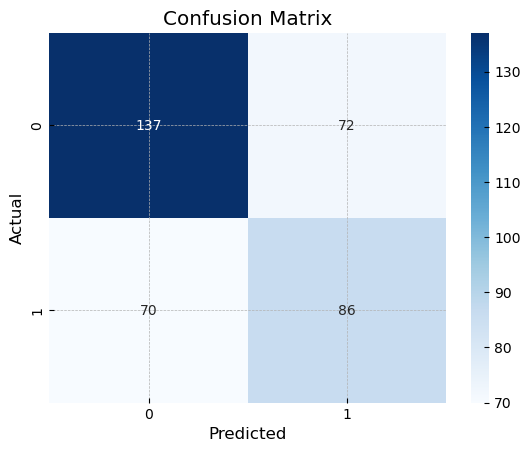

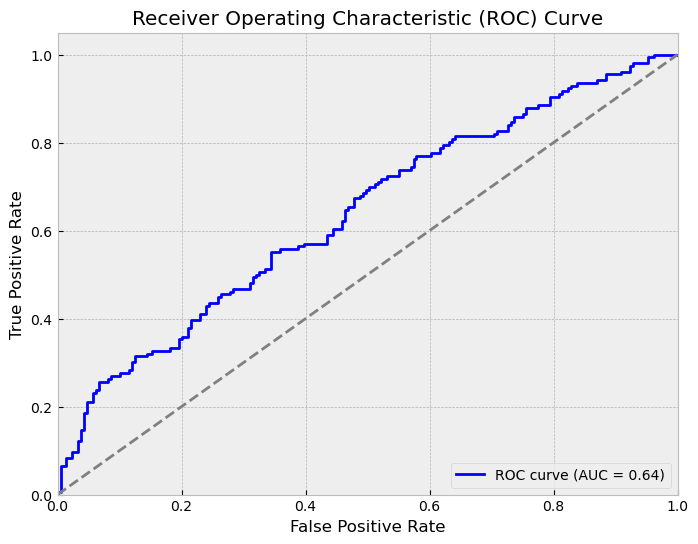

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       209
           1       0.54      0.55      0.55       156

    accuracy                           0.61       365
   macro avg       0.60      0.60      0.60       365
weighted avg       0.61      0.61      0.61       365



In [33]:
utils.Tools.performance_report(y_test, y_prob, optimal_threshold)